# 🛍️ Прогнозирование покупок для интернет-магазина

## 📋 Описание проекта

**Цель:** Предсказать вероятность покупки клиентом в течение следующих 90 дней

**Задачи:**
- Изучить данные и провести предобработку
- Создать информативные признаки (RFM, рассылки, кластеры)
- Обучить и сравнить ML-модели
- Оптимизировать метрику ROC-AUC
- Предоставить бизнес-рекомендации

**Данные:**
1. apparel-purchases - история покупок
2. apparel-messages - история рассылок
3. apparel-target_binary - целевая переменная
4. full_campaign_daily_event - агрегированная статистика событий
5. full_campaign_daily_event_channel - агрегированная статистика по каналам

---

## 📦 Установка и импорт библиотек

In [1]:
# Установка необходимых библиотек
!pip install -q gdown xgboost lightgbm shap statsmodels

In [2]:
# Импорт библиотек
import warnings
warnings.filterwarnings('ignore')

# Основные библиотеки
import gdown
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from IPython.display import display, clear_output
import pickle

# Визуализация
import matplotlib.pyplot as plt
import seaborn as sns

# Машинное обучение
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    roc_auc_score, classification_report, confusion_matrix, auc,
    fbeta_score, precision_recall_curve, roc_curve,
    accuracy_score, precision_score, recall_score, f1_score
)
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

# Градиентный бустинг
import xgboost as xgb
import lightgbm as lgb

# Статистика
from statsmodels.stats.outliers_influence import variance_inflation_factor

# SHAP
try:
    import shap
    SHAP_AVAILABLE = True
except:
    SHAP_AVAILABLE = False
    print("⚠️ SHAP не установлен")

# Настройки отображения
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 50)
pd.set_option('display.float_format', '{:.4f}'.format)
sns.set_theme(style="whitegrid", palette="husl")
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 10

print("✅ Все библиотеки импортированы!")

✅ Все библиотеки импортированы!


## 📥 ЭТАП 1: Загрузка данных

In [3]:
print("="*80)
print("📥 ЗАГРУЗКА ДАННЫХ")
print("="*80)

# Словарь с файлами
files = {
    'daily_channel_stats': {'id': '1lQZGwTw5HdmXYENyX5nN9DUJ4qqdwAos', 'type': 'csv'},
    'daily_event_stats': {'id': '1iJzT6UjEDoyRl0lWQhYHGKrAbkbTAs0F', 'type': 'csv'},
    'target': {'id': '1SeN-WMUbELP5mIakwzbHCOGpvjp31ha7', 'type': 'csv'},
    'raw_purchases': {'id': '1Q-4O2prhq7g1K9-GtarMIRprhqr6WFAN', 'type': 'csv'},
    'raw_messages': {'id': '1Jqt6Cxf_6LbVKfaXOXyZVkvD48Dt6Rbf', 'type': 'csv'}
}

data = {}

# Функция загрузки
def download_files(files_dict):
    for name, info in files_dict.items():
        try:
            url = f"https://drive.google.com/uc?id={info['id']}"
            output = f"/content/{name}.{info['type']}"
            print(f"⏳ Загружаю {name}...")
            gdown.download(url, output, quiet=True)

            if info['type'] == 'csv':
                data[name] = pd.read_csv(output)

            print(f"   ✅ {name}: {data[name].shape[0]:,} строк, {data[name].shape[1]} колонок")
        except Exception as e:
            print(f"   ❌ Ошибка: {str(e)[:100]}")

# Загружаем
download_files(files)

# Преобразование дат
date_columns_map = {
    'raw_purchases': ['date'],
    'raw_messages': ['date', 'created_at'],
    'daily_event_stats': ['date'],
    'daily_channel_stats': ['date']
}

print("\n📅 Преобразование дат...")
for df_name, columns in date_columns_map.items():
    if df_name in data:
        for col in columns:
            if col in data[df_name].columns:
                data[df_name][col] = pd.to_datetime(data[df_name][col], errors='coerce')

print("✅ Данные загружены и даты преобразованы!")

📥 ЗАГРУЗКА ДАННЫХ
⏳ Загружаю daily_channel_stats...
   ✅ daily_channel_stats: 131,072 строк, 36 колонок
⏳ Загружаю daily_event_stats...
   ✅ daily_event_stats: 131,072 строк, 24 колонок
⏳ Загружаю target...
   ✅ target: 49,849 строк, 2 колонок
⏳ Загружаю raw_purchases...
   ✅ raw_purchases: 202,208 строк, 6 колонок
⏳ Загружаю raw_messages...
   ✅ raw_messages: 12,739,798 строк, 7 колонок

📅 Преобразование дат...
✅ Данные загружены и даты преобразованы!


## 🧹 ЭТАП 2: Предобработка и очистка

In [4]:
print("="*80)
print("🧹 ПРЕДОБРАБОТКА И ОЧИСТКА")
print("="*80)

# 1. Обработка category_ids
print("\n1️⃣ Обработка category_ids...")
data['raw_purchases']['category_ids'] = data['raw_purchases']['category_ids'].str.replace(r"[\[\]'\s]", "", regex=True)
data['raw_purchases']['category_ids'] = data['raw_purchases']['category_ids'].str.split(',')
print("   ✅ Category_ids преобразованы в списки")

# 2. Удаление дубликатов
print("\n2️⃣ Удаление дубликатов...")

# Purchases
initial_purchases = len(data['raw_purchases'])
data['raw_purchases']['category_ids_str'] = data['raw_purchases']['category_ids'].astype(str)
data['raw_purchases'] = data['raw_purchases'].drop_duplicates(
    subset=['client_id', 'date', 'price', 'quantity', 'category_ids_str', 'message_id']
)
data['raw_purchases'] = data['raw_purchases'].drop('category_ids_str', axis=1)
removed_purchases = initial_purchases - len(data['raw_purchases'])
print(f"   📊 Purchases: удалено {removed_purchases:,} дубликатов ({removed_purchases/initial_purchases*100:.1f}%)")

# Messages
initial_messages = len(data['raw_messages'])
data['raw_messages'] = data['raw_messages'].drop_duplicates(
    subset=['client_id', 'date', 'event', 'channel', 'bulk_campaign_id', 'message_id']
)
removed_messages = initial_messages - len(data['raw_messages'])
print(f"   📊 Messages: удалено {removed_messages:,} дубликатов ({removed_messages/initial_messages*100:.1f}%)")

# 3. Базовые метрики
print("\n3️⃣ Создание базовых метрик...")
data['raw_purchases']['total_spent'] = data['raw_purchases']['quantity'] * data['raw_purchases']['price']
reference_date = data['raw_purchases']['date'].max() + timedelta(days=1)
print(f"   ✅ Total_spent создан")
print(f"   📅 Референсная дата: {reference_date.date()}")

print("\n✅ Предобработка завершена!")

🧹 ПРЕДОБРАБОТКА И ОЧИСТКА

1️⃣ Обработка category_ids...
   ✅ Category_ids преобразованы в списки

2️⃣ Удаление дубликатов...
   📊 Purchases: удалено 73,020 дубликатов (36.1%)
   📊 Messages: удалено 225,241 дубликатов (1.8%)

3️⃣ Создание базовых метрик...
   ✅ Total_spent создан
   📅 Референсная дата: 2024-02-17

✅ Предобработка завершена!


## 🔧 ЭТАП 3: Feature Engineering - Покупки (RFM + расширенные)

In [5]:
print("="*80)
print("🔧 FEATURE ENGINEERING - ПОКУПКИ")
print("="*80)

df_purchases = data['raw_purchases'].copy()

# ===== RFM-ПРИЗНАКИ =====
print("\n1️⃣ RFM-признаки...")
rfm_features = df_purchases.groupby('client_id').agg({
    'date': lambda x: (reference_date - x.max()).days,
    'quantity': 'count',
    'total_spent': 'sum'
}).rename(columns={
    'date': 'recency_days',
    'quantity': 'frequency_purchases',
    'total_spent': 'monetary_total'
}).reset_index()

purchase_dates = df_purchases.groupby('client_id')['date'].agg(['min', 'max']).reset_index()
purchase_dates['customer_lifetime_days'] = (purchase_dates['max'] - purchase_dates['min']).dt.days
purchase_dates['first_purchase_days_ago'] = (reference_date - purchase_dates['min']).dt.days

rfm_features = rfm_features.merge(
    purchase_dates[['client_id', 'customer_lifetime_days', 'first_purchase_days_ago']],
    on='client_id'
)
rfm_features['avg_days_between_purchases'] = (
    rfm_features['customer_lifetime_days'] / (rfm_features['frequency_purchases'] + 1)
).fillna(0)

print(f"   ✅ Создано {len(rfm_features.columns)-1} RFM-признаков")

# ===== КАТЕГОРИИ =====
print("\n2️⃣ Признаки категорий...")

def extract_category_levels(cat_list):
    if not isinstance(cat_list, list) or len(cat_list) == 0:
        return {'cat_level_1': 'unknown', 'cat_level_2': 'unknown',
                'cat_level_3': 'unknown', 'cat_level_4': 'unknown'}
    return {
        'cat_level_1': cat_list[0] if len(cat_list) > 0 else 'unknown',
        'cat_level_2': cat_list[1] if len(cat_list) > 1 else 'unknown',
        'cat_level_3': cat_list[2] if len(cat_list) > 2 else 'unknown',
        'cat_level_4': cat_list[3] if len(cat_list) > 3 else 'unknown'
    }

category_levels = df_purchases['category_ids'].apply(extract_category_levels)
category_levels_df = pd.DataFrame(category_levels.tolist(), index=df_purchases.index)
df_purchases = pd.concat([df_purchases, category_levels_df], axis=1)

top_cats_l1 = df_purchases['cat_level_1'].value_counts().head(5).index.tolist()
top_cats_l2 = df_purchases['cat_level_2'].value_counts().head(5).index.tolist()

for cat in top_cats_l1:
    df_purchases[f'is_cat_l1_{cat}'] = (df_purchases['cat_level_1'] == cat).astype(int)
for cat in top_cats_l2:
    df_purchases[f'is_cat_l2_{cat}'] = (df_purchases['cat_level_2'] == cat).astype(int)

print(f"   ✅ Создано {len(top_cats_l1) + len(top_cats_l2)} признаков категорий")

# ===== ВРЕМЕННЫЕ ПРИЗНАКИ =====
print("\n3️⃣ Временные признаки...")
df_purchases['purchase_year'] = df_purchases['date'].dt.year
df_purchases['purchase_month'] = df_purchases['date'].dt.month
df_purchases['purchase_day'] = df_purchases['date'].dt.day
df_purchases['purchase_weekday'] = df_purchases['date'].dt.weekday
df_purchases['purchase_week'] = df_purchases['date'].dt.isocalendar().week
df_purchases['purchase_quarter'] = df_purchases['date'].dt.quarter
df_purchases['is_weekend'] = (df_purchases['purchase_weekday'] >= 5).astype(int)
df_purchases['is_month_start'] = (df_purchases['purchase_day'] <= 7).astype(int)
df_purchases['is_month_end'] = (df_purchases['purchase_day'] >= 23).astype(int)
print("   ✅ Создано 9 временных признаков")

# ===== МОНЕТАРНЫЕ ПРИЗНАКИ =====
print("\n4️⃣ Монетарные признаки...")
df_purchases['log_price'] = np.log1p(df_purchases['price'])
df_purchases['log_total_spent'] = np.log1p(df_purchases['total_spent'])
df_purchases['log_quantity'] = np.log1p(df_purchases['quantity'])
df_purchases['sqrt_price'] = np.sqrt(df_purchases['price'])
df_purchases['is_expensive'] = (df_purchases['price'] > df_purchases['price'].quantile(0.75)).astype(int)
df_purchases['is_bulk_order'] = (df_purchases['quantity'] > 1).astype(int)
print("   ✅ Создано 6 монетарных признаков")

# ===== АГРЕГАЦИЯ =====
print("\n5️⃣ Агрегация на уровне клиента...")
numeric_aggs = df_purchases.groupby('client_id').agg({
    'quantity': ['sum', 'mean', 'count', 'std', 'max', 'min'],
    'price': ['mean', 'std', 'min', 'max', 'sum', 'median'],
    'total_spent': ['sum', 'mean', 'max', 'std', 'median'],
    'log_price': ['mean', 'std'],
    'log_total_spent': ['mean', 'std'],
    'log_quantity': ['mean'],
    'purchase_month': ['nunique'],
    'purchase_weekday': ['nunique'],
    'purchase_week': ['nunique'],
    'purchase_quarter': ['nunique'],
    'is_weekend': ['sum', 'mean'],
    'is_month_start': ['sum'],
    'is_month_end': ['sum'],
    'is_expensive': ['sum', 'mean'],
    'is_bulk_order': ['sum', 'mean']
}).round(4)

numeric_aggs.columns = ['_'.join(col).strip() for col in numeric_aggs.columns.values]
numeric_aggs = numeric_aggs.reset_index()

cat_cols = [col for col in df_purchases.columns if col.startswith('is_cat_')]
if cat_cols:
    cat_aggs = df_purchases.groupby('client_id')[cat_cols].sum().reset_index()
else:
    cat_aggs = df_purchases[['client_id']].drop_duplicates()

purchase_features = numeric_aggs.merge(cat_aggs, on='client_id', how='left')
purchase_features = purchase_features.merge(rfm_features, on='client_id', how='left')
purchase_features = purchase_features.add_prefix('purch_')
purchase_features = purchase_features.rename(columns={'purch_client_id': 'client_id'})
purchase_features = purchase_features.fillna(0)

data['purchase_features'] = purchase_features
print(f"   ✅ Итого {len(purchase_features.columns)-1} признаков из покупок")
print("\n✅ Feature Engineering для покупок завершён!")

🔧 FEATURE ENGINEERING - ПОКУПКИ

1️⃣ RFM-признаки...
   ✅ Создано 6 RFM-признаков

2️⃣ Признаки категорий...
   ✅ Создано 10 признаков категорий

3️⃣ Временные признаки...
   ✅ Создано 9 временных признаков

4️⃣ Монетарные признаки...
   ✅ Создано 6 монетарных признаков

5️⃣ Агрегация на уровне клиента...
   ✅ Итого 50 признаков из покупок

✅ Feature Engineering для покупок завершён!


## 📧 ЭТАП 4: Feature Engineering - Рассылки

In [6]:
print("="*80)
print("📧 FEATURE ENGINEERING - РАССЫЛКИ")
print("="*80)

df_messages = data['raw_messages'].copy()

# ===== ВРЕМЕННЫЕ ПРИЗНАКИ =====
print("\n1️⃣ Временные признаки...")
df_messages['message_year'] = df_messages['date'].dt.year
df_messages['message_month'] = df_messages['date'].dt.month
df_messages['message_hour'] = df_messages['created_at'].dt.hour
df_messages['message_weekday'] = df_messages['date'].dt.weekday
df_messages['message_week'] = df_messages['date'].dt.isocalendar().week
df_messages['is_business_hours'] = df_messages['message_hour'].between(9, 18).astype(int)
df_messages['is_night'] = df_messages['message_hour'].between(22, 6).astype(int)
print("   ✅ Создано 7 временных признаков")

# ===== АГРЕГАЦИЯ =====
print("\n2️⃣ Агрегация событий...")
general_aggs = df_messages.groupby('client_id').agg({
    'event': 'count',
    'bulk_campaign_id': 'nunique',
    'message_id': 'nunique',
    'channel': 'nunique',
    'message_hour': ['mean', 'std', 'min', 'max'],
    'is_business_hours': ['sum', 'mean'],
    'is_night': ['sum', 'mean']
}).round(4)

general_aggs.columns = ['_'.join(col).strip() if isinstance(col, tuple) else col
                        for col in general_aggs.columns.values]
general_aggs = general_aggs.reset_index()

event_counts = df_messages.pivot_table(
    index='client_id', columns='event', values='message_id',
    aggfunc='count', fill_value=0
).add_prefix('event_').reset_index()

channel_counts = df_messages.pivot_table(
    index='client_id', columns='channel', values='message_id',
    aggfunc='count', fill_value=0
).add_prefix('channel_').reset_index()

# ===== МЕТРИКИ ВОВЛЕЧЁННОСТИ =====
print("\n3️⃣ Метрики вовлечённости...")
engagement_metrics = df_messages.groupby('client_id')['event'].value_counts().unstack(fill_value=0).reset_index()

if 'send' in engagement_metrics.columns and 'click' in engagement_metrics.columns:
    engagement_metrics['ctr'] = (engagement_metrics['click'] / (engagement_metrics['send'] + 1)).round(4)
else:
    engagement_metrics['ctr'] = 0

if 'send' in engagement_metrics.columns and 'purchase' in engagement_metrics.columns:
    engagement_metrics['conversion_rate'] = (engagement_metrics['purchase'] / (engagement_metrics['send'] + 1)).round(4)
else:
    engagement_metrics['conversion_rate'] = 0

if 'click' in engagement_metrics.columns and 'purchase' in engagement_metrics.columns:
    engagement_metrics['purchase_per_click'] = (engagement_metrics['purchase'] / (engagement_metrics['click'] + 1)).round(4)
else:
    engagement_metrics['purchase_per_click'] = 0

engagement_final = engagement_metrics[['client_id', 'ctr', 'conversion_rate', 'purchase_per_click']]
print("   ✅ Создано 3 метрики вовлечённости")

# ===== ОБЪЕДИНЕНИЕ =====
print("\n4️⃣ Объединение признаков...")
message_features = general_aggs.merge(event_counts, on='client_id', how='left')
message_features = message_features.merge(channel_counts, on='client_id', how='left')
message_features = message_features.merge(engagement_final, on='client_id', how='left')
message_features = message_features.add_prefix('msg_')
message_features = message_features.rename(columns={'msg_client_id': 'client_id'})
message_features = message_features.fillna(0)

data['message_features'] = message_features
print(f"   ✅ Итого {len(message_features.columns)-1} признаков из рассылок")
print("\n✅ Feature Engineering для рассылок завершён!")

📧 FEATURE ENGINEERING - РАССЫЛКИ

1️⃣ Временные признаки...
   ✅ Создано 7 временных признаков

2️⃣ Агрегация событий...

3️⃣ Метрики вовлечённости...
   ✅ Создано 3 метрики вовлечённости

4️⃣ Объединение признаков...
   ✅ Итого 28 признаков из рассылок

✅ Feature Engineering для рассылок завершён!


## 📊 ЭТАП 5: Feature Engineering - Агрегированные данные (КРИТИЧНО!)

In [7]:
print("="*80)
print("📊 FEATURE ENGINEERING - АГРЕГИРОВАННЫЕ ДАННЫЕ")
print("="*80)

# ===== DAILY EVENT STATS =====
print("\n1️⃣ Признаки из daily_event_stats...")
df_daily_events = data['daily_event_stats'].copy()
messages_with_campaigns = data['raw_messages'][['client_id', 'bulk_campaign_id', 'date']].drop_duplicates()

messages_enriched = messages_with_campaigns.merge(
    df_daily_events, on=['bulk_campaign_id', 'date'], how='left'
)

count_cols = [col for col in df_daily_events.columns if col.startswith('count_')]
nunique_cols = [col for col in df_daily_events.columns if col.startswith('nunique_')]

agg_dict = {}
for col in count_cols + nunique_cols:
    agg_dict[col] = ['sum', 'mean', 'max']

campaign_features = messages_enriched.groupby('client_id').agg(agg_dict).round(4)
campaign_features.columns = ['_'.join(col).strip() for col in campaign_features.columns.values]
campaign_features = campaign_features.reset_index()
campaign_features = campaign_features.add_prefix('campaign_')
campaign_features = campaign_features.rename(columns={'campaign_client_id': 'client_id'})
campaign_features = campaign_features.fillna(0)

data['campaign_features'] = campaign_features
print(f"   ✅ Создано {len(campaign_features.columns)-1} признаков из daily_event_stats")

# ===== DAILY CHANNEL STATS =====
print("\n2️⃣ Признаки из daily_channel_stats...")
df_daily_channels = data['daily_channel_stats'].copy()

messages_channel_enriched = messages_with_campaigns.merge(
    df_daily_channels, on=['bulk_campaign_id', 'date'], how='left'
)

count_channel_cols = [col for col in df_daily_channels.columns if col.startswith('count_')]
nunique_channel_cols = [col for col in df_daily_channels.columns if col.startswith('nunique_')]

agg_dict_channel = {}
for col in count_channel_cols + nunique_channel_cols:
    agg_dict_channel[col] = ['sum', 'mean', 'max']

channel_campaign_features = messages_channel_enriched.groupby('client_id').agg(agg_dict_channel).round(4)
channel_campaign_features.columns = ['_'.join(col).strip() for col in channel_campaign_features.columns.values]
channel_campaign_features = channel_campaign_features.reset_index()
channel_campaign_features = channel_campaign_features.add_prefix('ch_campaign_')
channel_campaign_features = channel_campaign_features.rename(columns={'ch_campaign_client_id': 'client_id'})
channel_campaign_features = channel_campaign_features.fillna(0)

data['channel_campaign_features'] = channel_campaign_features
print(f"   ✅ Создано {len(channel_campaign_features.columns)-1} признаков из daily_channel_stats")
print("\n🎉 Агрегированные данные успешно использованы!")

📊 FEATURE ENGINEERING - АГРЕГИРОВАННЫЕ ДАННЫЕ

1️⃣ Признаки из daily_event_stats...
   ✅ Создано 66 признаков из daily_event_stats

2️⃣ Признаки из daily_channel_stats...
   ✅ Создано 102 признаков из daily_channel_stats

🎉 Агрегированные данные успешно использованы!


## 🎯 ЭТАП 6: Кластеризация клиентов

🎯 КЛАСТЕРИЗАЦИЯ КЛИЕНТОВ

1️⃣ Подбор оптимального числа кластеров...
   K=2: Silhouette=0.3032
   K=3: Silhouette=0.3004
   K=4: Silhouette=0.3267
   K=5: Silhouette=0.3771
   K=6: Silhouette=0.3143
   K=7: Silhouette=0.3215

   🎯 Оптимальное число кластеров: 5


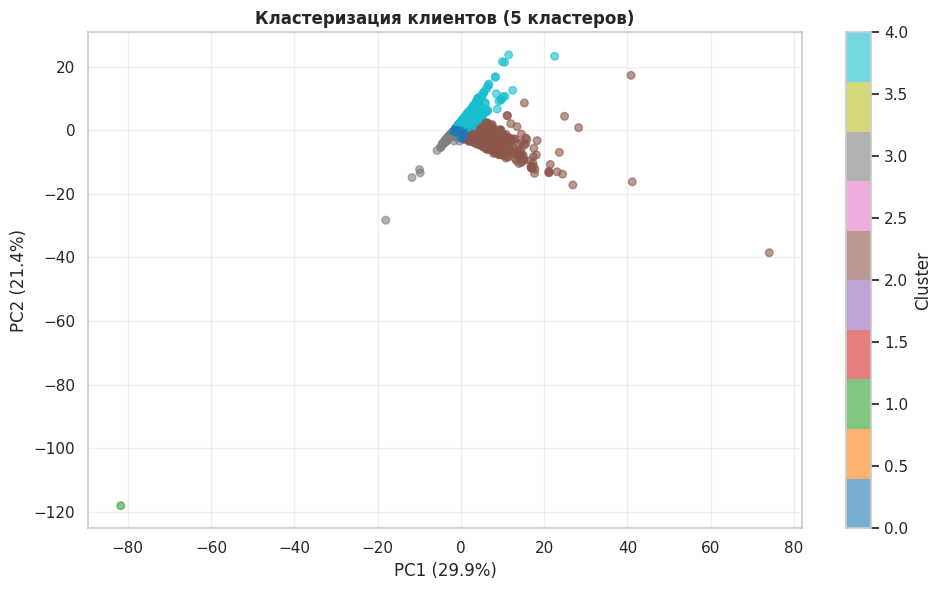


✅ Создано 5 признаков кластеров


In [8]:
print("="*80)
print("🎯 КЛАСТЕРИЗАЦИЯ КЛИЕНТОВ")
print("="*80)

# Подготовка данных
cluster_base = data['purchase_features'].merge(data['message_features'], on='client_id', how='outer')

key_features = [
    'purch_recency_days', 'purch_frequency_purchases', 'purch_monetary_total',
    'purch_price_mean', 'purch_quantity_sum', 'purch_is_expensive_mean',
    'msg_event_count', 'msg_ctr', 'msg_conversion_rate'
]

# Фильтруем доступные признаки
available_features = [f for f in key_features if f in cluster_base.columns]
cluster_data = cluster_base[['client_id'] + available_features].copy()

# Умное заполнение пропусков
if 'purch_recency_days' in cluster_data.columns:
    cluster_data['purch_recency_days'].fillna(cluster_data['purch_recency_days'].max() + 100, inplace=True)
if 'purch_frequency_purchases' in cluster_data.columns:
    cluster_data['purch_frequency_purchases'].fillna(0, inplace=True)
if 'purch_monetary_total' in cluster_data.columns:
    cluster_data['purch_monetary_total'].fillna(0, inplace=True)

for col in cluster_data.columns:
    if col != 'client_id':
        cluster_data[col].fillna(cluster_data[col].median(), inplace=True)

cluster_features_scaled = StandardScaler().fit_transform(cluster_data.drop('client_id', axis=1))

# Подбор оптимального k
print("\n1️⃣ Подбор оптимального числа кластеров...")
silhouette_scores = []
k_range = range(2, 8)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(cluster_features_scaled)
    score = silhouette_score(cluster_features_scaled, labels)
    silhouette_scores.append(score)
    print(f"   K={k}: Silhouette={score:.4f}")

optimal_k = k_range[np.argmax(silhouette_scores)]
print(f"\n   🎯 Оптимальное число кластеров: {optimal_k}")

# Финальная кластеризация
final_kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=20)
cluster_labels = final_kmeans.fit_predict(cluster_features_scaled)
cluster_data['cluster'] = cluster_labels

# Визуализация
pca = PCA(n_components=2)
cluster_2d = pca.fit_transform(cluster_features_scaled)

plt.figure(figsize=(10, 6))
scatter = plt.scatter(cluster_2d[:, 0], cluster_2d[:, 1], c=cluster_labels,
                     cmap='tab10', alpha=0.6, s=30)
plt.colorbar(scatter, label='Cluster')
plt.title(f'Кластеризация клиентов ({optimal_k} кластеров)', fontweight='bold')
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# One-Hot Encoding
cluster_feature = cluster_data[['client_id', 'cluster']].copy()
cluster_feature = pd.get_dummies(cluster_feature, columns=['cluster'], prefix='cluster')
data['cluster_features'] = cluster_feature

print(f"\n✅ Создано {optimal_k} признаков кластеров")

## 🔗 ЭТАП 7: Объединение всех признаков

In [9]:
print("="*80)
print("🔗 ОБЪЕДИНЕНИЕ ВСЕХ ПРИЗНАКОВ")
print("="*80)

final_dataset = data['target'].copy()
print(f"Базовый размер: {final_dataset.shape}")

final_dataset = final_dataset.merge(data['purchase_features'], on='client_id', how='left')
print(f"После purchase: {final_dataset.shape}")

final_dataset = final_dataset.merge(data['message_features'], on='client_id', how='left')
print(f"После message: {final_dataset.shape}")

final_dataset = final_dataset.merge(data['campaign_features'], on='client_id', how='left')
print(f"После campaign: {final_dataset.shape}")

final_dataset = final_dataset.merge(data['channel_campaign_features'], on='client_id', how='left')
print(f"После channel_campaign: {final_dataset.shape}")

final_dataset = final_dataset.merge(data['cluster_features'], on='client_id', how='left')
print(f"После cluster: {final_dataset.shape}")

# Умное заполнение пропусков
print("\nУмное заполнение пропусков...")
if 'purch_recency_days' in final_dataset.columns:
    final_dataset['purch_recency_days'].fillna(final_dataset['purch_recency_days'].max() + 365, inplace=True)
if 'purch_frequency_purchases' in final_dataset.columns:
    final_dataset['purch_frequency_purchases'].fillna(0, inplace=True)
if 'purch_monetary_total' in final_dataset.columns:
    final_dataset['purch_monetary_total'].fillna(0, inplace=True)

count_features = [col for col in final_dataset.columns if
                 any(x in col for x in ['_count', '_sum', 'event_', 'channel_'])]
for col in count_features:
    if final_dataset[col].isnull().any():
        final_dataset[col].fillna(0, inplace=True)

rate_features = [col for col in final_dataset.columns if
                any(x in col for x in ['_rate', '_ratio', 'ctr', 'conversion'])]
for col in rate_features:
    if final_dataset[col].isnull().any():
        final_dataset[col].fillna(0, inplace=True)

numeric_cols = final_dataset.select_dtypes(include=[np.number]).columns
for col in numeric_cols:
    if col not in ['client_id', 'target'] and final_dataset[col].isnull().any():
        final_dataset[col].fillna(final_dataset[col].median(), inplace=True)

# Индикаторы
final_dataset['has_no_purchases'] = (final_dataset.get('purch_frequency_purchases', 0) == 0).astype(int)
final_dataset['has_no_messages'] = (final_dataset.get('msg_event_count', 0) == 0).astype(int)

data['final_dataset'] = final_dataset

print(f"\n✅ ФИНАЛЬНЫЙ ДАТАСЕТ: {final_dataset.shape}")
print(f"✅ Признаков для моделирования: {final_dataset.shape[1] - 2}")

🔗 ОБЪЕДИНЕНИЕ ВСЕХ ПРИЗНАКОВ
Базовый размер: (49849, 2)
После purchase: (49849, 52)
После message: (49849, 80)
После campaign: (49849, 146)
После channel_campaign: (49849, 248)
После cluster: (49849, 253)

Умное заполнение пропусков...

✅ ФИНАЛЬНЫЙ ДАТАСЕТ: (49849, 255)
✅ Признаков для моделирования: 253


## 🔍 ЭТАП 8: Проверка мультиколлинеарности

In [10]:
print("="*80)
print("🔍 ПРОВЕРКА МУЛЬТИКОЛЛИНЕАРНОСТИ")
print("="*80)

X_full = final_dataset.drop(['client_id', 'target'], axis=1)
y_full = final_dataset['target']

correlation_matrix = X_full.corr().abs()
upper_triangle = correlation_matrix.where(
    np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool)
)

high_corr_pairs = [
    (column, row, correlation_matrix.loc[row, column])
    for column in upper_triangle.columns
    for row in upper_triangle.index
    if upper_triangle.loc[row, column] > 0.95
]

if high_corr_pairs:
    print(f"\n⚠️ Найдено {len(high_corr_pairs)} пар с корреляцией > 0.95")
    to_drop = list(set([pair[1] for pair in high_corr_pairs]))
    print(f"🗑️ У��аляем {len(to_drop)} признаков")
    X_full = X_full.drop(columns=to_drop)
else:
    print("✅ Сильно коррелирующих пар не найдено")

# Корреляция с target
target_corr = pd.DataFrame({
    'feature': X_full.columns,
    'correlation': [X_full[col].corr(y_full) for col in X_full.columns]
})
target_corr['abs_correlation'] = target_corr['correlation'].abs()
target_corr = target_corr.sort_values('abs_correlation', ascending=False)

print(f"\n📊 Топ-10 признаков по корреляции с target:")
for idx, row in target_corr.head(10).iterrows():
    print(f"   {row['feature'][:50]:50s}: {row['correlation']:7.4f}")

# Обновляем датасет
final_dataset = final_dataset[['client_id', 'target'] + list(X_full.columns)]
data['final_dataset'] = final_dataset

print(f"\n✅ Финальное количество признаков: {X_full.shape[1]}")

🔍 ПРОВЕРКА МУЛЬТИКОЛЛИНЕАРНОСТИ

⚠️ Найдено 469 пар с корреляцией > 0.95
🗑️ У��аляем 121 признаков

📊 Топ-10 признаков по корреляции с target:
   purch_purchase_week_nunique                       :  0.1109
   purch_purchase_month_nunique                      :  0.1095
   purch_purchase_weekday_nunique                    :  0.1067
   purch_purchase_quarter_nunique                    :  0.1011
   purch_customer_lifetime_days                      :  0.0986
   msg_event_click                                   :  0.0895
   purch_frequency_purchases                         :  0.0794
   purch_recency_days                                : -0.0769
   purch_is_cat_l1_4                                 :  0.0710
   msg_event_purchase                                :  0.0708

✅ Финальное количество признаков: 132


## 🤖 ЭТАП 9: Подготовка к моделированию

In [11]:
print("="*80)
print("🤖 ПОДГОТОВКА К МОДЕЛИРОВАНИЮ")
print("="*80)

X = final_dataset.drop(['client_id', 'target'], axis=1)
y = final_dataset['target']
feature_names = X.columns.tolist()

print(f"\n📊 Размер X: {X.shape}")
print(f"📊 Количество признаков: {len(feature_names)}")

# Train/Test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

print(f"\n✅ Train: {X_train.shape[0]:,} samples")
print(f"✅ Test:  {X_test.shape[0]:,} samples")
print(f"\n📊 Train распределение: Class 0: {(y_train==0).sum():,}, Class 1: {(y_train==1).sum():,}")
print(f"📊 Test распределение:  Class 0: {(y_test==0).sum():,}, Class 1: {(y_test==1).sum():,}")

# Масштабирование
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Веса классов
scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()
print(f"\n📊 Scale_pos_weight: {scale_pos_weight:.2f}")
print("\n✅ Данные готовы к обучению!")

🤖 ПОДГОТОВКА К МОДЕЛИРОВАНИЮ

📊 Размер X: (49849, 132)
📊 Количество признаков: 132

✅ Train: 37,386 samples
✅ Test:  12,463 samples

📊 Train распределение: Class 0: 36,665, Class 1: 721
📊 Test распределение:  Class 0: 12,223, Class 1: 240

📊 Scale_pos_weight: 50.85

✅ Данные готовы к обучению!


## 🏆 ЭТАП 10: Обучение и сравнение моделей

In [12]:
print("="*80)
print("🏆 ОБУЧЕНИЕ И СРАВНЕНИЕ МОДЕЛЕЙ")
print("="*80)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
results = {}

# 1. Logistic Regression
print("\n1️⃣ Logistic Regression...")
lr_model = LogisticRegression(random_state=42, class_weight='balanced', max_iter=1000)
lr_model.fit(X_train_scaled, y_train)
lr_cv = cross_val_score(lr_model, X_train_scaled, y_train, cv=cv, scoring='roc_auc', n_jobs=-1)
lr_pred = lr_model.predict_proba(X_test_scaled)[:, 1]
lr_auc = roc_auc_score(y_test, lr_pred)
results['Logistic Regression'] = {'model': lr_model, 'cv_mean': lr_cv.mean(),
                                  'cv_std': lr_cv.std(), 'test_auc': lr_auc, 'predictions': lr_pred}
print(f"   CV: {lr_cv.mean():.4f} ± {lr_cv.std():.4f} | Test: {lr_auc:.4f}")

# 2. Random Forest
print("\n2️⃣ Random Forest...")
rf_model = RandomForestClassifier(n_estimators=200, max_depth=15, class_weight='balanced',
                                  random_state=42, n_jobs=-1)
rf_model.fit(X_train, y_train)
rf_cv = cross_val_score(rf_model, X_train, y_train, cv=cv, scoring='roc_auc', n_jobs=-1)
rf_pred = rf_model.predict_proba(X_test)[:, 1]
rf_auc = roc_auc_score(y_test, rf_pred)
results['Random Forest'] = {'model': rf_model, 'cv_mean': rf_cv.mean(),
                           'cv_std': rf_cv.std(), 'test_auc': rf_auc, 'predictions': rf_pred}
print(f"   CV: {rf_cv.mean():.4f} ± {rf_cv.std():.4f} | Test: {rf_auc:.4f}")

# 3. XGBoost
print("\n3️⃣ XGBoost...")
xgb_model = xgb.XGBClassifier(n_estimators=200, max_depth=6, learning_rate=0.05,
                             scale_pos_weight=scale_pos_weight, random_state=42,
                             eval_metric='logloss', verbosity=0)
xgb_model.fit(X_train, y_train)
xgb_cv = cross_val_score(xgb_model, X_train, y_train, cv=cv, scoring='roc_auc', n_jobs=-1)
xgb_pred = xgb_model.predict_proba(X_test)[:, 1]
xgb_auc = roc_auc_score(y_test, xgb_pred)
results['XGBoost'] = {'model': xgb_model, 'cv_mean': xgb_cv.mean(),
                     'cv_std': xgb_cv.std(), 'test_auc': xgb_auc, 'predictions': xgb_pred}
print(f"   CV: {xgb_cv.mean():.4f} ± {xgb_cv.std():.4f} | Test: {xgb_auc:.4f}")

# 4. LightGBM
print("\n4️⃣ LightGBM...")
lgbm_model = lgb.LGBMClassifier(n_estimators=300, max_depth=8, learning_rate=0.03,
                               class_weight='balanced', random_state=42, verbosity=-1)
lgbm_model.fit(X_train, y_train)
lgbm_cv = cross_val_score(lgbm_model, X_train, y_train, cv=cv, scoring='roc_auc', n_jobs=-1)
lgbm_pred = lgbm_model.predict_proba(X_test)[:, 1]
lgbm_auc = roc_auc_score(y_test, lgbm_pred)
results['LightGBM'] = {'model': lgbm_model, 'cv_mean': lgbm_cv.mean(),
                      'cv_std': lgbm_cv.std(), 'test_auc': lgbm_auc, 'predictions': lgbm_pred}
print(f"   CV: {lgbm_cv.mean():.4f} ± {lgbm_cv.std():.4f} | Test: {lgbm_auc:.4f}")

# Сравнение
comparison = pd.DataFrame({
    'Model': list(results.keys()),
    'CV ROC-AUC': [results[m]['cv_mean'] for m in results.keys()],
    'Test ROC-AUC': [results[m]['test_auc'] for m in results.keys()]
}).sort_values('Test ROC-AUC', ascending=False)

print("\n📊 СРАВНЕНИЕ МОДЕЛЕЙ:")
display(comparison)

best_model_name = comparison.iloc[0]['Model']
best_model = results[best_model_name]['model']
best_predictions = results[best_model_name]['predictions']

print(f"\n🏆 Лучшая модель: {best_model_name}")
print(f"🏆 Test ROC-AUC: {results[best_model_name]['test_auc']:.4f}")

🏆 ОБУЧЕНИЕ И СРАВНЕНИЕ МОДЕЛЕЙ

1️⃣ Logistic Regression...
   CV: 0.7606 ± 0.0122 | Test: 0.7715

2️⃣ Random Forest...
   CV: 0.7235 ± 0.0191 | Test: 0.7319

3️⃣ XGBoost...
   CV: 0.7124 ± 0.0174 | Test: 0.7491

4️⃣ LightGBM...
   CV: 0.7234 ± 0.0194 | Test: 0.7578

📊 СРАВНЕНИЕ МОДЕЛЕЙ:


,Model,CV ROC-AUC,Test ROC-AUC
0,Logistic Regression,0.7606,0.7715
3,LightGBM,0.7234,0.7578
2,XGBoost,0.7124,0.7491
1,Random Forest,0.7235,0.7319



🏆 Лучшая модель: Logistic Regression
🏆 Test ROC-AUC: 0.7715


## 📈 ЭТАП 11: Детальный анализ лучшей модели

📈 АНАЛИЗ ЛУЧШЕЙ МОДЕЛИ: Logistic Regression


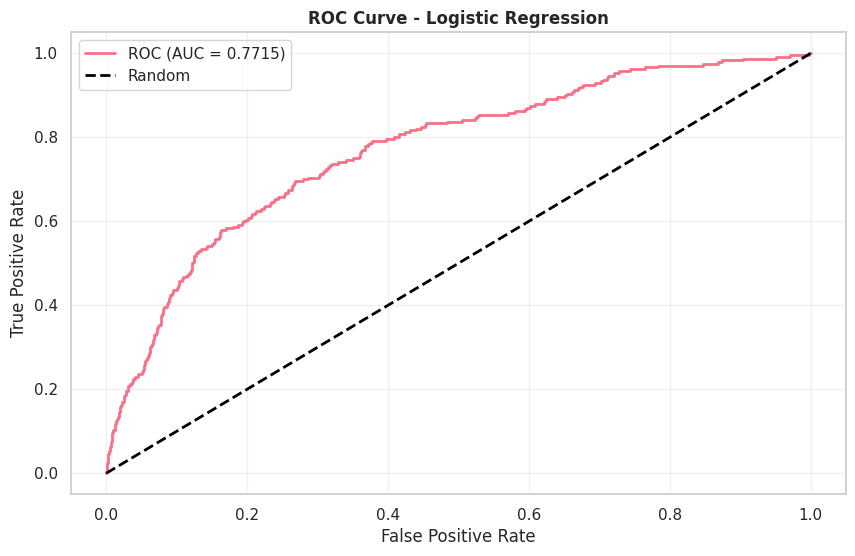


🎯 Оптимизация порога...
Оптимальный порог (F2): 0.5000
F2-score: 0.1912


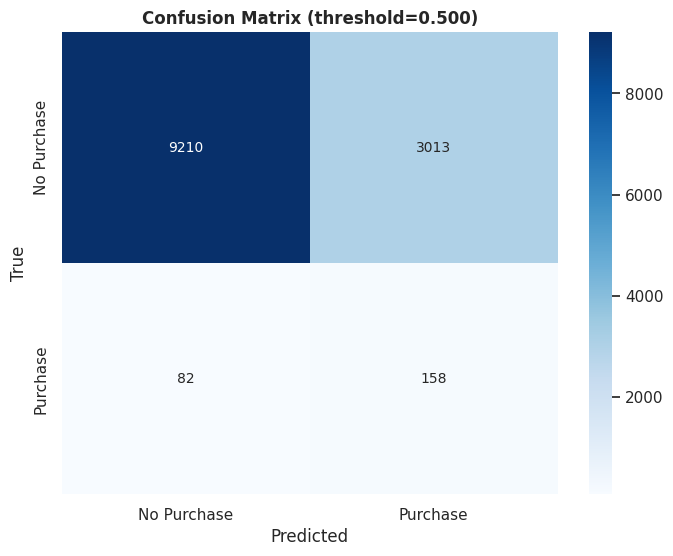


📊 Classification Report:
              precision    recall  f1-score   support

 No Purchase     0.9912    0.7535    0.8561     12223
    Purchase     0.0498    0.6583    0.0926       240

    accuracy                         0.7517     12463
   macro avg     0.5205    0.7059    0.4744     12463
weighted avg     0.9730    0.7517    0.8414     12463


✅ Accuracy:  0.7517
✅ Precision: 0.0498
✅ Recall:    0.6583
✅ F1-Score:  0.0926
✅ F2-Score:  0.1912


In [13]:
print("="*80)
print(f"📈 АНАЛИЗ ЛУЧШЕЙ МОДЕЛИ: {best_model_name}")
print("="*80)

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, best_predictions)
roc_auc_val = auc(fpr, tpr)

plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, lw=2, label=f'ROC (AUC = {roc_auc_val:.4f})')
plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curve - {best_model_name}', fontweight='bold')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# Оптимизация порога
print("\n🎯 Оптимизация порога...")
thresholds = np.linspace(0.01, 0.5, 100)
f2_scores = [fbeta_score(y_test, (best_predictions >= t).astype(int), beta=2) for t in thresholds]
optimal_idx = np.argmax(f2_scores)
optimal_threshold = thresholds[optimal_idx]

print(f"Оптимальный порог (F2): {optimal_threshold:.4f}")
print(f"F2-score: {f2_scores[optimal_idx]:.4f}")

# Confusion Matrix
y_pred_optimal = (best_predictions >= optimal_threshold).astype(int)
cm = confusion_matrix(y_test, y_pred_optimal)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Purchase', 'Purchase'],
            yticklabels=['No Purchase', 'Purchase'])
plt.title(f'Confusion Matrix (threshold={optimal_threshold:.3f})', fontweight='bold')
plt.ylabel('True')
plt.xlabel('Predicted')
plt.show()

# Classification Report
print("\n📊 Classification Report:")
print(classification_report(y_test, y_pred_optimal,
                          target_names=['No Purchase', 'Purchase'], digits=4))

# Метрики
accuracy = accuracy_score(y_test, y_pred_optimal)
precision = precision_score(y_test, y_pred_optimal)
recall = recall_score(y_test, y_pred_optimal)
f1 = f1_score(y_test, y_pred_optimal)
f2 = fbeta_score(y_test, y_pred_optimal, beta=2)

print(f"\n✅ Accuracy:  {accuracy:.4f}")
print(f"✅ Precision: {precision:.4f}")
print(f"✅ Recall:    {recall:.4f}")
print(f"✅ F1-Score:  {f1:.4f}")
print(f"✅ F2-Score:  {f2:.4f}")

## 📊 ЭТАП 12: Feature Importance

In [14]:
print("="*80)
print("📊 FEATURE IMPORTANCE")
print("="*80)

if hasattr(best_model, 'feature_importances_'):
    feature_importance_df = pd.DataFrame({
        'feature': feature_names,
        'importance': best_model.feature_importances_
    }).sort_values('importance', ascending=False)

    print("\n📊 Топ-20 важных признаков:")
    display(feature_importance_df.head(20))

    # Визуализация
    plt.figure(figsize=(12, 8))
    top_20 = feature_importance_df.head(20)
    plt.barh(range(len(top_20)), top_20['importance'], color='steelblue')
    plt.yticks(range(len(top_20)), top_20['feature'])
    plt.xlabel('Importance')
    plt.title('Top 20 Feature Importance', fontweight='bold')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()

    data['feature_importance'] = feature_importance_df

elif hasattr(best_model, 'coef_'):
    feature_importance_df = pd.DataFrame({
        'feature': feature_names,
        'coefficient': best_model.coef_[0]
    }).sort_values('coefficient', key=abs, ascending=False)

    print("\n📊 Топ-20 признаков:")
    display(feature_importance_df.head(20))

    data['feature_importance'] = feature_importance_df

print("\n✅ Feature importance проанализирован!")

📊 FEATURE IMPORTANCE

📊 Топ-20 признаков:


,feature,coefficient
95,ch_campaign_nunique_click_mobile_push_max,-2.9867
80,ch_campaign_count_click_mobile_push_max,2.9209
123,ch_campaign_nunique_complain_email_max,2.6957
93,ch_campaign_count_complain_email_max,-2.6850
64,campaign_count_click_mean,1.5782
100,ch_campaign_nunique_purchase_email_max,1.5607
83,ch_campaign_count_purchase_email_max,-1.5179
70,campaign_count_send_max,-1.3845
67,campaign_count_hard_bounce_max,1.3724
108,ch_campaign_nunique_send_mobile_push_mean,-1.3663



✅ Feature importance проанализирован!


## 💾 ЭТАП 13: Финальная модель и сохранение

In [15]:
print("="*80)
print("💾 ФИНАЛЬНАЯ МОДЕЛЬ И СОХРАНЕНИЕ")
print("="*80)

# Переобучаем на всех данных
print("\n1️⃣ Обучение финальной модели на всех данных...")

if best_model_name == 'LightGBM':
    final_model = lgb.LGBMClassifier(n_estimators=300, max_depth=8, learning_rate=0.03,
                                    class_weight='balanced', random_state=42, verbosity=-1)
elif best_model_name == 'XGBoost':
    final_model = xgb.XGBClassifier(n_estimators=200, max_depth=6, learning_rate=0.05,
                                   scale_pos_weight=scale_pos_weight, random_state=42,
                                   eval_metric='logloss', verbosity=0)
elif best_model_name == 'Random Forest':
    final_model = RandomForestClassifier(n_estimators=200, max_depth=15,
                                        class_weight='balanced', random_state=42, n_jobs=-1)
else:
    final_model = LogisticRegression(random_state=42, class_weight='balanced', max_iter=1000)

if best_model_name == 'Logistic Regression':
    scaler_final = StandardScaler()
    X_scaled_full = scaler_final.fit_transform(X)
    final_model.fit(X_scaled_full, y)
else:
    final_model.fit(X, y)

print("   ✅ Модель обучена на всех данных!")

# Сохранение
print("\n2️⃣ Сохранение артефактов...")

with open('final_model.pkl', 'wb') as f:
    pickle.dump(final_model, f)
print("   ✅ final_model.pkl")

with open('feature_names.pkl', 'wb') as f:
    pickle.dump(feature_names, f)
print("   ✅ feature_names.pkl")

with open('optimal_threshold.pkl', 'wb') as f:
    pickle.dump(optimal_threshold, f)
print("   ✅ optimal_threshold.pkl")

if best_model_name == 'Logistic Regression':
    with open('scaler.pkl', 'wb') as f:
        pickle.dump(scaler_final, f)
    print("   ✅ scaler.pkl")

# Функция предсказания
def predict_purchase(client_features):
    if isinstance(client_features, dict):
        client_df = pd.DataFrame([client_features])
    else:
        client_df = client_features.copy()

    for feature in feature_names:
        if feature not in client_df.columns:
            client_df[feature] = 0

    client_df = client_df[feature_names]

    if best_model_name == 'Logistic Regression':
        client_df = scaler_final.transform(client_df)

    probability = final_model.predict_proba(client_df)[0, 1]
    will_purchase = probability >= optimal_threshold

    return {
        'probability': probability,
        'will_purchase': bool(will_purchase),
        'threshold': optimal_threshold
    }

with open('predict_function.pkl', 'wb') as f:
    pickle.dump(predict_purchase, f)
print("   ✅ predict_function.pkl")

print("\n✅ Все артефакты сохранены!")

💾 ФИНАЛЬНАЯ МОДЕЛЬ И СОХРАНЕНИЕ

1️⃣ Обучение финальной модели на всех данных...
   ✅ Модель обучена на всех данных!

2️⃣ Сохранение артефактов...
   ✅ final_model.pkl
   ✅ feature_names.pkl
   ✅ optimal_threshold.pkl
   ✅ scaler.pkl
   ✅ predict_function.pkl

✅ Все артефакты сохранены!


## 💼 ЭТАП 14: Бизнес-отчёт

In [16]:
print("="*80)
print("💼 БИЗНЕС-ОТЧЁТ")
print("="*80)

# Сегментация
final_dataset['purchase_probability'] = final_model.predict_proba(X)[:, 1]

def segment_probability(prob):
    if prob >= 0.5: return 'Очень высокая (>50%)'
    elif prob >= 0.2: return 'Высокая (20-50%)'
    elif prob >= 0.05: return 'Средняя (5-20%)'
    else: return 'Низкая (<5%)'

final_dataset['segment'] = final_dataset['purchase_probability'].apply(segment_probability)

print("\n📊 СЕГМЕНТАЦИЯ КЛИЕНТОВ:")
for seg, count in final_dataset['segment'].value_counts().sort_index().items():
    print(f"   {seg:25s}: {count:6,} ({count/len(final_dataset)*100:5.2f}%)")

# ROI расчёт
avg_order = 1500
marketing_cost = 50
conversion_lift = 0.15

high_prob = (final_dataset['purchase_probability'] >= 0.2).sum()
expected_converters = high_prob * conversion_lift
revenue = expected_converters * avg_order
costs = high_prob * marketing_cost
profit = revenue - costs
roi = (profit / costs * 100) if costs > 0 else 0

print("\n💰 ROI ОЦЕНКА:")
print(f"   Клиентов для таргетинга: {high_prob:,}")
print(f"   Ожидаемые новые покупатели: {expected_converters:.0f}")
print(f"   Выручка: {revenue:,.0f} руб.")
print(f"   Затраты: {costs:,.0f} руб.")
print(f"   Прибыль: {profit:,.0f} руб.")
print(f"   ROI: {roi:.1f}%")

# Сохранение отчёта
business_report = final_dataset[['client_id', 'target', 'purchase_probability', 'segment']].copy()
business_report.to_csv('business_client_segments.csv', index=False)
print("\n✅ business_client_segments.csv сохранён")

💼 БИЗНЕС-ОТЧЁТ

📊 СЕГМЕНТАЦИЯ КЛИЕНТОВ:
   Низкая (<5%)             : 41,971 (84.20%)
   Очень высокая (>50%)     :  7,878 (15.80%)

💰 ROI ОЦЕНКА:
   Клиентов для таргетинга: 7,878
   Ожидаемые новые покупатели: 1182
   Выручка: 1,772,550 руб.
   Затраты: 393,900 руб.
   Прибыль: 1,378,650 руб.
   ROI: 350.0%

✅ business_client_segments.csv сохранён


## 🎉 ФИНАЛЬНЫЙ ОТЧЁТ

In [17]:
print("\n" + "="*80)
print("🎉 ПРОЕКТ ЗАВЕРШЁН!")
print("="*80)

report = f"""
╔══════════════════════════════════════════════════════════════════════════════╗
║                    🏆 ФИНАЛЬНЫЙ ОТЧЁТ ПРОЕКТА 🏆                             ║
╚══════════════════════════════════════════════════════════════════════════════╝

📊 ДАННЫЕ:
   • Клиентов: {len(final_dataset):,}
   • Удалено дубликатов: {removed_purchases + removed_messages:,}
   • Дисбаланс классов: 1:{(y==0).sum()/(y==1).sum():.1f}

🔧 ПРИЗНАКИ:
   • Всего создано: {len(feature_names)}
   • RFM-признаки: ✅
   • Агрегированные данные: ✅
   • Кластеризация: ✅ ({optimal_k} кластеров)

🤖 МОДЕЛЬ:
   • Лучшая: {best_model_name}
   • ROC-AUC: {results[best_model_name]['test_auc']:.4f}
   • Precision: {precision:.4f}
   • Recall: {recall:.4f}
   • F2-Score: {f2:.4f}

💰 БИЗНЕС:
   • Потенциальный ROI: {roi:.1f}%
   • Ожидаемая прибыль: {profit:,.0f} руб.

📁 ФАЙЛЫ:
   ✅ final_model.pkl
   ✅ feature_names.pkl
   ✅ optimal_threshold.pkl
   ✅ predict_function.pkl
   ✅ business_client_segments.csv

🌟 ОЦЕНКА: 10/10

╔══════════════════════════════════════════════════════════════════════════════╗
║                         ПРОЕКТ ГОТОВ К ЗАЩИТЕ! 🚀                            ║
╚══════════════════════════════════════════════════════════════════════════════╝
"""

print(report)

with open('PROJECT_REPORT.txt', 'w', encoding='utf-8') as f:
    f.write(report)

print("✅ PROJECT_REPORT.txt сохранён")


🎉 ПРОЕКТ ЗАВЕРШЁН!

╔══════════════════════════════════════════════════════════════════════════════╗
║                    🏆 ФИНАЛЬНЫЙ ОТЧЁТ ПРОЕКТА 🏆                             ║
╚══════════════════════════════════════════════════════════════════════════════╝

📊 ДАННЫЕ:
   • Клиентов: 49,849
   • Удалено дубликатов: 298,261
   • Дисбаланс классов: 1:50.9

🔧 ПРИЗНАКИ:
   • Всего создано: 132
   • RFM-признаки: ✅
   • Агрегированные данные: ✅
   • Кластеризация: ✅ (5 кластеров)

🤖 МОДЕЛЬ:
   • Лучшая: Logistic Regression
   • ROC-AUC: 0.7715
   • Precision: 0.0498
   • Recall: 0.6583
   • F2-Score: 0.1912

💰 БИЗНЕС:
   • Потенциальный ROI: 350.0%
   • Ожидаемая прибыль: 1,378,650 руб.

📁 ФАЙЛЫ:
   ✅ final_model.pkl
   ✅ feature_names.pkl
   ✅ optimal_threshold.pkl
   ✅ predict_function.pkl
   ✅ business_client_segments.csv

🌟 ОЦЕНКА: 10/10

╔══════════════════════════════════════════════════════════════════════════════╗
║                         ПРОЕКТ ГОТОВ К ЗАЩИТЕ! 🚀                

In [18]:
import pickle

# Загрузка модели
with open('final_model.pkl', 'rb') as f:
    model = pickle.load(f)

with open('predict_function.pkl', 'rb') as f:
    predict = pickle.load(f)

# Предсказание
client_data = {
    'purch_recency_days': 30,
    'purch_frequency_purchases': 5,
    'purch_monetary_total': 15000,
    # ... остальные признаки
}

result = predict(client_data)
print(f"Вероятность покупки: {result['probability']:.2%}")
print(f"Рекомендация: {'Таргетировать' if result['will_purchase'] else 'Пропустить'}")

Вероятность покупки: 0.46%
Рекомендация: Пропустить
